<div class="alert alert-block alert-info">
    <b>Tip:</b> Use <b>%matplotlib widget</b> or <b>%matplotlib notebook</b> for interactive plots when notebook is running locally on your computer
</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CARDIAL-nyu/cmr-playground/blob/main/golden_angle_sample/OCMR%20Extras.ipynb)

In [1]:
import sys
# interactive matplotlib doesn't work on google colab, so fall back to inline
if 'miniconda' not in sys.executable:
    %matplotlib inline
    !{sys.executable} -m pip install --force https://github.com/chengs/tqdm/archive/colab.zip
    !{sys.executable} -m pip install sigpy h5py tqdm
    ! git clone -b notes https://github.com/CARDIAL-nyu/cmr-playground
    %cd cmr-playground/golden_angle_sample
else:
    %matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io
import seaborn as sns
import sigpy
import sigpy.plot
import sigpy.mri
import ismrmrd
import ismrmrd.xsd
import h5py
if 'miniconda' not in sys.executable:
    from tqdm import trange, tqdm
else:
    from tqdm.notebook import trange, tqdm

plt.style.use('fivethirtyeight')
five_thirty_eight = [
"#30a2da",
"#fc4f30",
"#e5ae38",
"#6d904f",
"#8b8b8b",
]
sns.set_palette(five_thirty_eight, color_codes=True)
sns.set_color_codes()

mpl.rcParams['axes.grid'] = False

# Noise Covariance from Multicoil Data

In [3]:
def return_Psi(noise_scan_ncnx, do_plot=False):
    """ Helper function that returns noise covariance for coils
    
    :param noise_scan_ncnx: noise scans [Nc, Nx]
    :returns: noise covariance matrix [Nc, Nc]
    """
    n_noise_samples = noise_scan_ncnx.shape[1]
    Psi = (np.asmatrix(noise_scan_ncnx)*np.asmatrix(noise_scan_ncnx).H)/(n_noise_samples-1)
    Psi = np.asarray(Psi)
    if do_plot:
        plt.figure()
        plt.imshow(np.abs(Psi), cmap='gray')
    return Psi

def do_prewhiten(kdata, Psi):
    """ Applies Psi to whiten kspace data
    
    :param kdata: kspace data [Nc, ...]
    :param Psi: noise covariance [Nc, Nc]
    :returns: whitened kspace data
    """
    _kdata = kdata.copy()
    _kdata = _kdata.reshape((Psi.shape[0], -1))
    
    L = np.linalg.cholesky(Psi)
    x = np.linalg.solve(L, _kdata)
    
    return x.reshape(kdata.shape)

def imshow_2col_linked(col1, col2, rowlabels=None, collabels=None, invertyaxis=False, hideticks=True):
    """ Helper function to plot a n_coil x 2 grid of images 
    
    :param col1: n_coil x 2D array, coil dimension first [n_coil, nx, ny]
    :param col2: n_coil x 2D array, coil dimension first [n_coil, nx, ny]
    :param rowlabels: list, labels for each row, len(rowlabels) == n_coil
    :param collabels: list, labels for each column, len(collabels) == 2
    :param invertyaxis: bool, invert the y-axis
    :param hideticks: bool, hide ticks on x- and y-axes
    :returns: (figure, axes)
    """
    _col1 = np.asarray(col1).copy()
    _col2 = np.asarray(col2).copy()
    
    assert _col1.shape[0] == _col2.shape[0]
    
    if rowlabels is not None:
        assert len(rowlabels) == _col1.shape[0]
    if collabels is not None:
        assert len(collabels) == 2
    
    if np.iscomplexobj(_col1):
        _col1 = np.abs(_col1)
    if np.iscomplexobj(_col2):
        _col2 = np.abs(_col2)
        
    
    f_g, ax_g = plt.subplots(nrows=_col1.shape[0], ncols=2,
                            sharex=True, sharey=True, figsize=(8, int(4*_col1.shape[0])))
    
    if ax_g.ndim == 1:
        ax_g = ax_g[np.newaxis,...]
    
    for an_idx, an_ax in enumerate(ax_g[:,0]):
        an_ax.set_title(f'{an_idx+1}')
        an_ax.imshow(_col1[an_idx,:,:], cmap='gray')
        if hideticks:
            an_ax.set_xticks([])
            an_ax.set_yticks([])
        if rowlabels is not None: an_ax.set_ylabel(rowlabels[an_idx])
        if an_idx+1 == _col1.shape[0] and collabels is not None:
            an_ax.set_xlabel(collabels[0])
    
    for an_idx, an_ax in enumerate(ax_g[:,1]):
        an_ax.set_title(f'{an_idx+1}')
        an_ax.imshow(_col2[an_idx,:,:], cmap='gray')
        if hideticks:
            an_ax.set_xticks([])
            an_ax.set_yticks([])
        if an_idx+1 == _col1.shape[0] and collabels is not None:
            an_ax.set_xlabel(collabels[1])
            
    if invertyaxis: an_ax.invert_yaxis()
    f_g.tight_layout()
            
    return f_g, ax_g

In [4]:
from tqdm.notebook import tqdm, trange
filename='/mnt/e/ocmr_data/us_0156_pt_1_5T.h5'

dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

# loop through the acquisitions looking for noise scans
firstacq=0
for acqnum in trange(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)

    # Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        #print("Found noise scan at acq ", acqnum)
        continue
    else:
        firstacq = acqnum
        print("Imaging acquisition starts acq ", acqnum)
        break

  0%|          | 0/5972 [00:00<?, ?it/s]

Imaging acquisition starts acq  32


In [5]:
# Grab the noise scan
noise_scan = list()
for acqnum in trange(firstacq):
    noise_scan.append(dset.read_acquisition(acqnum).data)
    
noise_scan = np.asarray(noise_scan)

  0%|          | 0/32 [00:00<?, ?it/s]

In [6]:
noise_scan.shape

(32, 20, 352)

/home/tsphan/miniconda3/envs/xdgrasp_torch/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


<IPython.core.display.Javascript object>


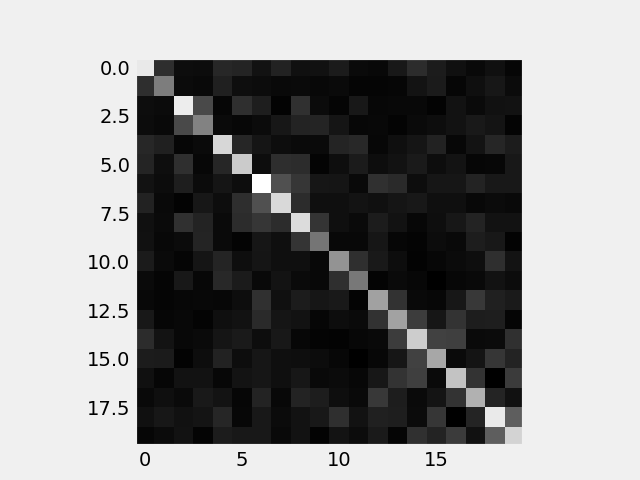

In [7]:
Psi = return_Psi(np.mean(noise_scan, axis=0), do_plot=True)

<IPython.core.display.Javascript object>


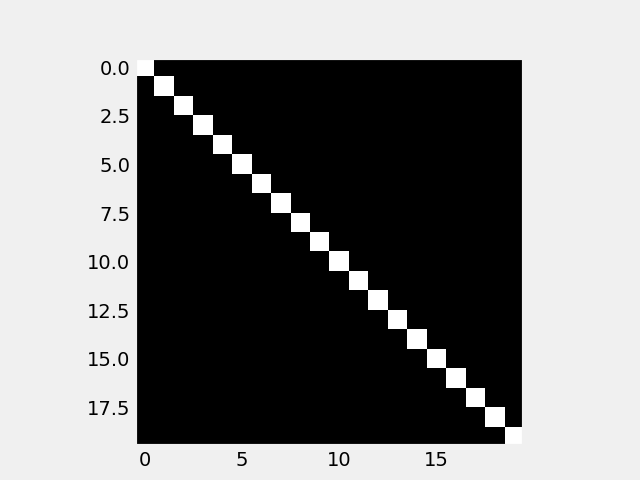

In [8]:
# Quick sanity-check of the whitening process
whitened_noise = do_prewhiten(np.mean(noise_scan, axis=0), Psi)

# Should see unit variance on diagnonals if noise was properly whitened
return_Psi(whitened_noise, do_plot=True);

# Load in a sample OCMR reconstruction

In [9]:
reconstructed_filename = 'output_slice1_us_0156_pt_1_5T_reshapeF_slice4.mat'
slice_mat = scipy.io.loadmat(reconstructed_filename)

# What's inside this container...
slice_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'xHat', 'pOut', 'xHat_abs_norm'])

In [10]:
n_ro, n_pe, n_frames = slice_mat['xHat_abs_norm'].shape
n_ro, n_pe, n_frames

(352, 134, 30)

(352, 352)


<IPython.core.display.Javascript object>


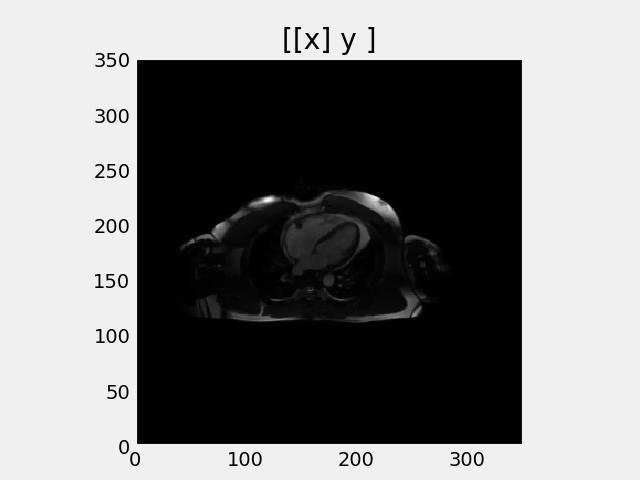

In [11]:
selected_frame = 0 # let's work with just the 1st frame of the cine
square_cine = np.zeros((n_ro, n_ro))
square_cine[:,(n_ro-n_pe)//2:-(n_ro-n_pe)//2] = slice_mat['xHat_abs_norm'][...,selected_frame]
print(square_cine.shape)

sigpy.plot.ImagePlot(square_cine, x=0, y=1)

# Read in the coil sensitivity maps

20 352 126 (20, 352, 352)


<IPython.core.display.Javascript object>


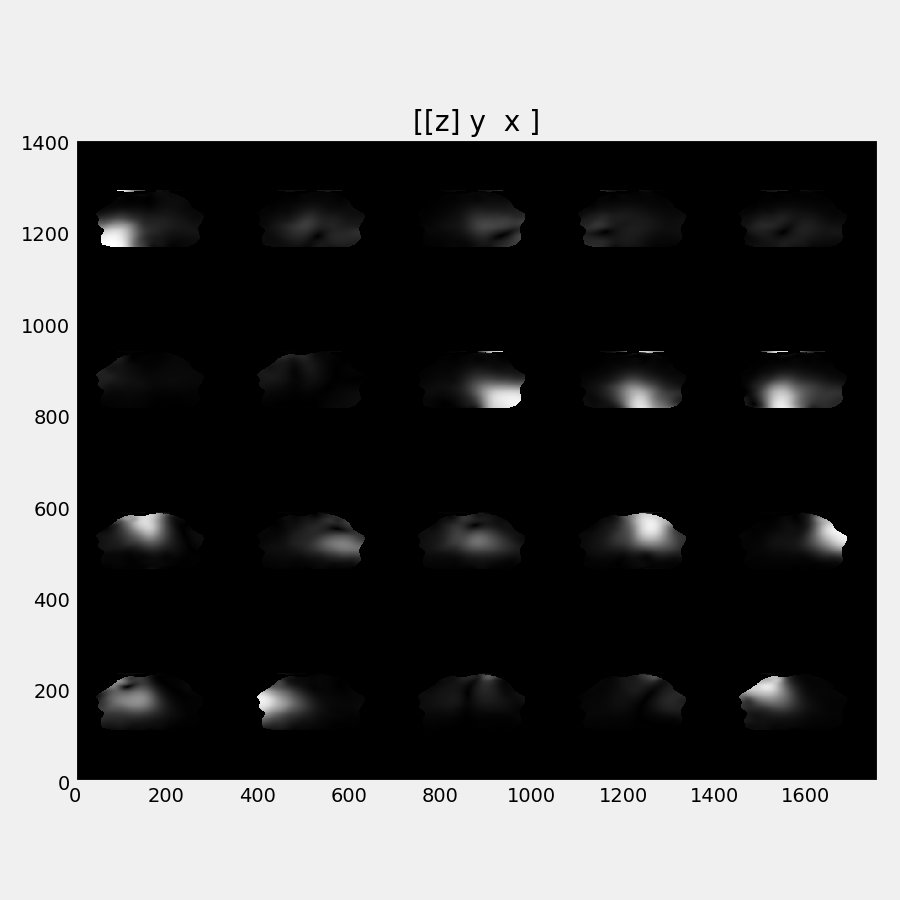

In [12]:
ocmr_id = reconstructed_filename.split('_reshape')[0].replace('output_slice1_','')
a_coil_sense_map = scipy.io.loadmat(f'espirit_{ocmr_id}.mat')['espirit_map']

n_coils_sense, n_ro_sense, n_pe_sense = a_coil_sense_map.shape

square_sense_map = np.zeros((n_coils_sense, n_ro_sense, n_ro_sense), dtype=complex)
square_sense_map[:, :,(n_ro_sense-n_pe_sense)//2:-(n_ro_sense-n_pe_sense)//2] = a_coil_sense_map

print(n_coils_sense, n_ro_sense, n_pe_sense, square_sense_map.shape)

i_coil_maps = sigpy.plot.ImagePlot(square_sense_map.transpose((0,2,1)), z=0) # transpose so the body is horizontal

i_coil_maps.fig.set_figwidth(9)
i_coil_maps.fig.set_figheight(9)

i_coil_maps.fig.tight_layout()

# Pre-whiten coil sensitivity maps with `Psi`

<IPython.core.display.Javascript object>


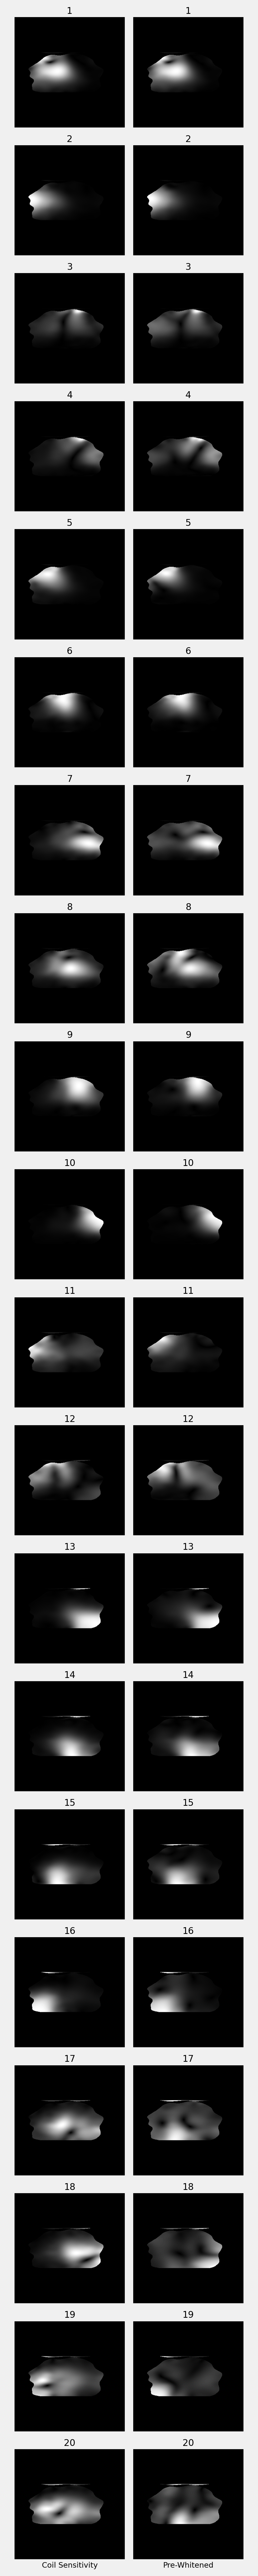

In [13]:
imshow_2col_linked(square_sense_map.transpose((0,2,1)),
                   do_prewhiten(square_sense_map, Psi).transpose((0,2,1)),
                   collabels=['Coil Sensitivity', 'Pre-Whitened'], invertyaxis=True);

# Examples of Normal and "Broken" Coils

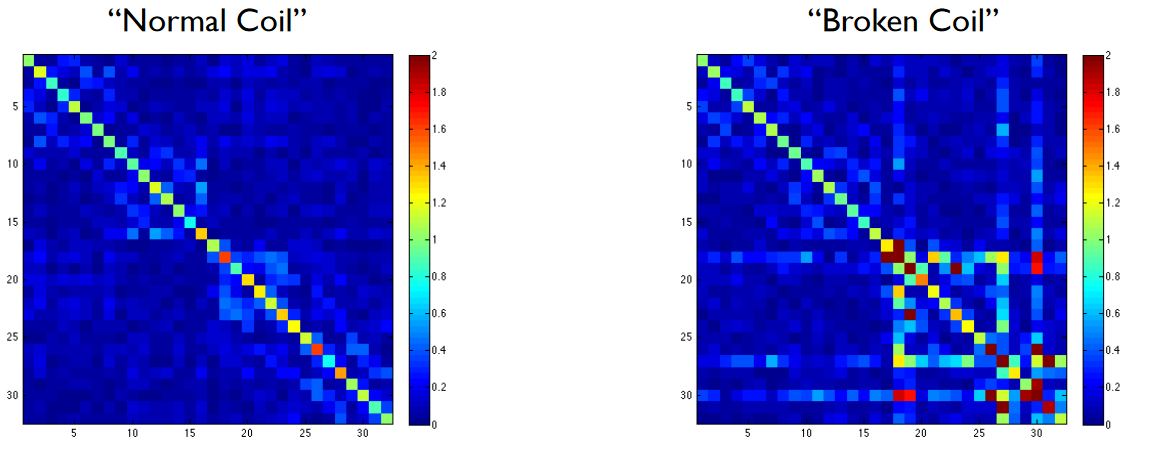

# Example Effects of Pre-Whitening with imperfect coils

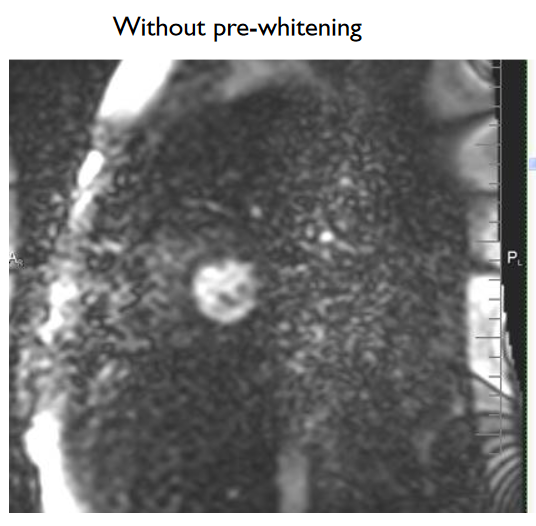

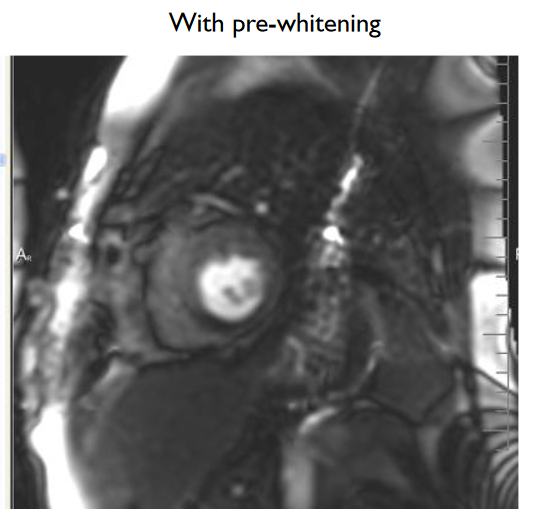

```html
<img src="" />
```